In [1]:
import pandas as pd
import altair as alt
import umap
from semvecpy.vectors import semvec_utils as semvec

%matplotlib inline
alt.renderers.enable('notebook')
import imp
esp_ddi_util = imp.load_source('esp_ddi_util', 'esp_ddi_util.py')

In [2]:
!conda list | grep umap
!conda list | grep scikit-learn
!conda list | grep altair
!conda list | grep vega
!conda list | grep pandas
!conda list | grep notebook
!conda list | grep semvecpy

umap-learn                0.3.9                    py36_0    conda-forge
scikit-learn              0.19.1           py36hf9f1f73_0  
altair                    3.1.0                    py36_0    conda-forge
vega                      2.4.0                    py36_0    conda-forge
pandas                    0.24.2           py36h86efe34_0    conda-forge
notebook                  6.0.0                    py36_0    conda-forge
semvecpy                  0.1.3              pyh5ca1d4c_0    conda-forge


# Load data
For this notebook we will need the following data:
* **Test data**. To make our results directly comparable, we use the train/test splits produced by our Decagon run. This notebook evaluates our trained vectors with this test set.
* **Mappings of drug and side effect IDs to their names**. Using names instead of IDs makes interpretation of the trained representations more convenient. While the side effect names come with the _bio-decagon_ data sets, the drug IDs had to be resolved separately using [version 2 of the STITCH ID database](http://stitch2.embl.de/). For convenience, files with the mappings are included in the repository. 
* **Trained vectors**. This notebook shows the evaluation of our trained vectors, provided as part of the zenodo repository.

## Load names

In [3]:
drug_names_df = pd.read_csv("drug_names.csv", header=None)
drug_names_df.columns = ["drug", "drug_name"]
# rename drugs to conform to ESP subject/object convention
drug_names_df.drug_name = drug_names_df.drug_name.apply(
    lambda x: x.replace(" ", "_").lower())
drug_names_df.head()

,drug,drug_name
0,CID000000085,carnitine
1,CID000000119,gaba
2,CID000000143,leucovorin
3,CID000000158,pge2
4,CID000000159,prostacyclin


In [4]:
# create dictionary for later drug lookup
drug_names = drug_names_df.set_index('drug').to_dict()['drug_name']

side_effect_names_df = pd.read_csv(
    "side_effect_names.tsv", sep='\t', header=None)
side_effect_names_df.columns = ["side_effect", "side_effect_name"]

# rename side effects to conform to ESP predicate convention
side_effect_names_df.side_effect_name = side_effect_names_df.side_effect_name.apply(
    lambda x: x.replace(" ", "_").upper())
side_effect_names_df.head()

,side_effect,side_effect_name
0,C0151714,HYPERMAGNESEMIA
1,C0035344,RETINOPATHY_OF_PREMATURITY
2,C0004144,ATELECTASIS
3,C0002063,ALKALOSIS
4,C0004604,BACK_ACHE


In [5]:
side_effect_names = side_effect_names_df.set_index(
    "side_effect").to_dict()["side_effect_name"]

# examples
drug_names['CID000000853'], side_effect_names['C0035344']

('thyroxine', 'RETINOPATHY_OF_PREMATURITY')

## Load splits
The provided data sets were output by our own version of the Decagon code, available in the companion repository at https://github.com/hannahburkhardt/decagon. They are available for download from our zenodo repository at [TBD]. Predictions produced by this Decagon run are also available there.

The zenodo repository also contains a set of trained vector binaries produced by ESP, as well as a jar of the version of the semanticvector library used in this project. You may also download the source code from https://github.com/semanticvectors/semanticvectors and build semanticvectors yourself.

In [6]:
import os
if not os.path.exists("esp_ddi_zenodo.tar.gz"):
    !cd ..; wget https://zenodo.org/record/3333834/files/esp_ddi_zenodo.tar.gz
    # if wget is not installed, use the following command instead
    #!curl -o esp_ddi_zenodo.tar.gz https://zenodo.org/record/3333834/files/esp_ddi_zenodo.tar.gz
    !cd ..; tar -xzvf esp_ddi_zenodo.tar.gz

--2019-10-27 23:04:43--  https://zenodo.org/record/3333834/files/esp_ddi_zenodo.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.65.20
Connecting to zenodo.org (zenodo.org)|188.184.65.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188659542 (180M) [application/octet-stream]
Saving to: ‘esp_ddi_zenodo.tar.gz.1’

esp_ddi_zenodo.tar. 100%[===================>] 179.92M   791KB/s    in 5m 42s  

2019-10-27 23:10:27 (538 KB/s) - ‘esp_ddi_zenodo.tar.gz.1’ saved [188659542/188659542]

x zenodo/
x zenodo/semanticvectors-5.9.jar
x zenodo/decagon_split_train_drug_protein.tsv
x zenodo/esp_vectors_16k_8cycles/
x zenodo/decagon_scores_8_epochs.txt
x zenodo/decagon_split_test_ddi_pos.tsv
x zenodo/decagon_split_train_ddi.tsv
x zenodo/decagon_split_test_ddi_neg.tsv
x zenodo/decagon_split_val_ddi_pos.tsv
x zenodo/decagon_split_train_ppi.tsv
x zenodo/decagon_split_val_ddi_neg.tsv
x zenodo/esp_vectors_16k_8cycles/elementalvectors.bin
x zenodo/esp_vectors_16k_8cycles/predic

In [7]:
file_location = "../zenodo/"

# Test data
test_ddi_pos = pd.read_csv(
    file_location + 'decagon_split_test_ddi_pos.tsv', sep="\t", header=None)
test_ddi_neg = pd.read_csv(
    file_location + 'decagon_split_test_ddi_neg.tsv', sep="\t", header=None)


In [8]:
test_ddi_pos.head()

,0,1,2
0,CID000002244,C0004144,CID000003365
1,CID000003440,C0004144,CID000004691
2,CID000003957,C0004144,CID000004075
3,CID000004168,C0004144,CID000005090
4,CID000001117,C0004144,CID000077993


## Prep data

### Resolve IDs to names
For readability, resolve drug and side effect IDs to names. No need to resolve protein IDs.

In [9]:
resolve_drug_id = lambda drug_id: drug_names[drug_id] if drug_id in drug_names.keys() else drug_id
resolve_side_effect_id = lambda side_effect_id: side_effect_names[side_effect_id[:-2]]+"-2" if side_effect_id[-2:]=="-2" else side_effect_names[side_effect_id]

def resolve_names_ddi_df(df):
    df['subject'] = df[0].apply(resolve_drug_id)
    df['predicate'] = df[1].apply(resolve_side_effect_id)
    df['object'] = df[2].apply(resolve_drug_id)


In [10]:
for df in [test_ddi_pos, test_ddi_neg]:
    resolve_names_ddi_df(df)


In [11]:
test_ddi_pos.head(5)

,0,1,2,subject,predicate,object
0,CID000002244,C0004144,CID000003365,aspirin,ATELECTASIS,fluconazole
1,CID000003440,C0004144,CID000004691,furosemide,ATELECTASIS,paroxetine
2,CID000003957,C0004144,CID000004075,loratadine,ATELECTASIS,5-aminosalicylic_acid
3,CID000004168,C0004144,CID000005090,metoclopramide,ATELECTASIS,rofecoxib
4,CID000001117,C0004144,CID000077993,sulfate,ATELECTASIS,eletriptan


### Create files with test data
ESP accepts input files with tab separated subject-predicate-object triples. Here, we write the data to the _outputs_ directory in this format.

In [12]:
%%bash
mkdir -p ../outputs/

In [13]:
file_location = "../outputs/" 

all_test_pos = test_ddi_pos[['subject', 'predicate', 'object']]
# remove reversed side effects for testing
all_test_pos = all_test_pos[~all_test_pos.predicate.str.contains("-2")]

all_test_neg = test_ddi_neg[['subject', 'predicate', 'object']]
# remove reversed side effects for testing
all_test_neg = all_test_neg[~all_test_neg.predicate.str.contains("-2")]


In [14]:
len(all_test_pos.predicate.unique())

963

### Create files with evaluation strings
For testing, we determine the similarity between the representatation of the drug pair, `S(drug1)*E(drug2)`, and the representation of the side effect, `P(side effect)`. Semanticvectors accepts a file with a list of these, one per line.

In [15]:
make_string = lambda row: "S({})*E({})|P({})".format(row.subject, row.object, row.predicate)

positive_test_strings = all_test_pos.apply(make_string, axis=1)
negative_test_strings = all_test_neg.apply(make_string, axis=1)

# Evaluation

## Make predictions on test set
Next, we make predictions for each triple in the test set by determining the similarity of the bound representations for the 2 drugs with the representation for the side effect.

This will take a couple of minutes depending on vector dimensionality.

In [16]:
predicate_vectors = semvec.readfile('../zenodo/esp_vectors_16k_8cycles/predicatevectors.bin')
semantic_vectors = semvec.readfile('../zenodo/esp_vectors_16k_8cycles/semanticvectors.bin')
elemental_vectors = semvec.readfile('../zenodo/esp_vectors_16k_8cycles/elementalvectors.bin')

16000   BINARY
16000   BINARY
16000   BINARY


In [17]:
positive_scores = semvec.compare_terms_batch(positive_test_strings,
                                            predicate_vectors=predicate_vectors,
                                            elemental_vectors=elemental_vectors,
                                            semantic_vectors=semantic_vectors)
negative_scores = semvec.compare_terms_batch(negative_test_strings,
                                            predicate_vectors=predicate_vectors,
                                            elemental_vectors=elemental_vectors,
                                            semantic_vectors=semantic_vectors)

## Performance
We evaluate performance of our model by determining the AUROC, AUPRC, and AP@50 for each individual side effect. Performance is then reported as the average performance across the 963 side effects. This allows a direct comparison to the Decagon model's performance, which is reported in this way. Note that this approach causes the average AUROC to be higher than the overall AUROC if some high-performance side effects have few examples or low-performance side effects have many examples.

In [20]:
all_test_pos.head()

,subject_name,predicate_name,object_name
0,aspirin,ATELECTASIS,fluconazole
1,furosemide,ATELECTASIS,paroxetine
2,loratadine,ATELECTASIS,5-aminosalicylic_acid
3,metoclopramide,ATELECTASIS,rofecoxib
4,sulfate,ATELECTASIS,eletriptan


Positive results mean score: 0.352
Negative results mean score: 0.136
Overall AUROC: 0.889
Overall AUPRC: 0.854
Overall AP50: 0.949

Average performance over 963 side effects:
       median   mean    std    sem    min    max
auroc   0.903  0.903  0.023  0.001  0.841  0.977
auprc   0.873  0.875  0.034  0.001  0.779  0.976
ap50    0.873  0.865  0.073  0.002  0.550  1.000


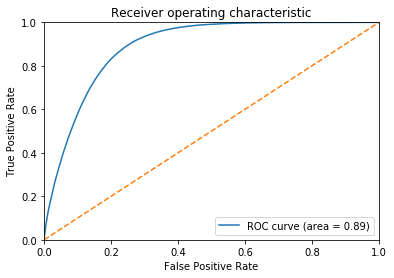

In [21]:
esp_aurocs_by_se = esp_ddi_util.get_aurocs_by_side_effect(all_test_pos, all_test_neg, positive_scores, negative_scores)

In [22]:
esp_aurocs_by_se.head()

,auroc,auprc,ap50,negative_examples,positive_examples
predicate_name,,,,,
ABDOMINAL_DISTENSION,0.875768,0.833755,0.896605,1236,1236
ABDOMINAL_HERNIA,0.939464,0.936977,1.000000,275,275
ABDOMINAL_PAIN,0.874220,0.833877,0.829504,2141,2141
ABDOMINAL_PAIN_UPPER,0.877330,0.836777,0.879883,1316,1316
ABNORMAL_CERVICAL_SMEAR,0.899219,0.860803,0.744635,66,66


Best and worst performing side effects for each measure:

In [23]:
for c in ['auroc', 'auprc', 'ap50']:
    print(c)
    print('min:', esp_aurocs_by_se[c].idxmin(), round(esp_aurocs_by_se[c].min(
    ), 3), 'max:', esp_aurocs_by_se[c].idxmax(), round(esp_aurocs_by_se[c].max(), 3))
    print()

auroc
min: PATENT_DUCTUS_ARTERIOSIS 0.841 max: MUMPS 0.977

auprc
min: CAESAREAN_SECTION 0.779 max: MUMPS 0.976

ap50
min: CAROTID_ARTERY_STENOSIS 0.55 max: ABDOMINAL_HERNIA 1.0



### Performance distribution
Distribution of AUROCs: Does the model perform either well or poorly for most side effects, or are they normally distributed?

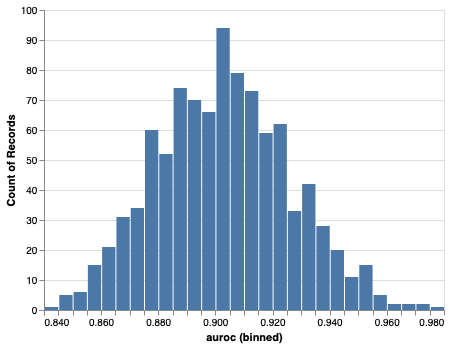

In [24]:
alt.Chart(esp_aurocs_by_se).mark_bar().encode(
    x=alt.X(
        'auroc', 
        bin=alt.Bin(maxbins=50)
    ), 
    y='count()', 
    tooltip=[
        alt.Tooltip('count()')
    ]
)

### Performance by side effect frequency
Does performance differ significantly depending on the number of examples we have for each side effect?

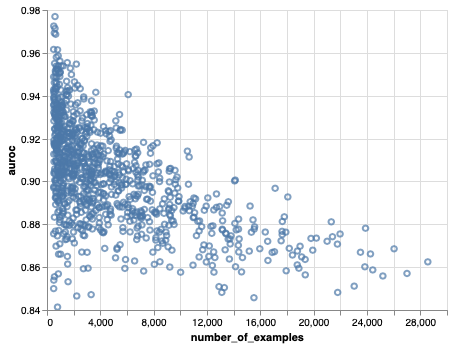

In [25]:
# the positive testing examples constitute 10% of the total number of samples in the dataset
alt.Chart(
    esp_aurocs_by_se.reset_index()
).mark_point().encode(
    alt.Y(
        'auroc',
        scale=alt.Scale(zero=False)
    ),
    x='number_of_examples:Q',
    tooltip=['predicate_name', 'number_of_examples:Q']
).transform_calculate(
    number_of_examples=alt.datum.positive_examples*10
)

This chart shows that performance is, on average, higher if there are fewer examples. This may be the case for a number of reasons, including that commonly reported side effects, such as nausea, may have a more noisy signal precisely because they are generally common and thus may not always be due to the particular combination of drugs. On the other hand, the model may be overfitting rare side effects, such as mumps, and performance may thus be inflated for these side effects.

### Score distribution by label
How are scores for positive and negative examples distributed?

In [26]:
file_location='../outputs/'
pos_scores = pd.read_csv(file_location + "positive_examples_scores.txt",
                         header=None).rename(columns={0: 'score'})
pos_scores['truth'] = 1
neg_scores = pd.read_csv(file_location + "negative_examples_scores.txt",
                         header=None).rename(columns={0: 'score'})
neg_scores['truth'] = 0
scores = pos_scores.append(neg_scores)
scores.head()

,score,truth
0,0.209250,1
1,0.239750,1
2,0.196000,1
3,0.399125,1
4,0.027500,1


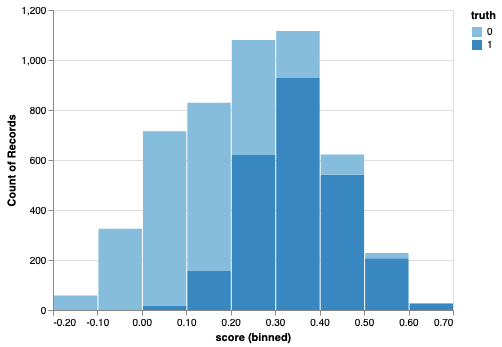

In [27]:
alt.Chart(scores.sample(5000)).mark_bar().encode(
    x=alt.X("score", bin=True), 
    y='count()', 
    color='truth:O'
)

## Dimensionality analysis

How low can we go in dimensionality and still preserve acceptable performance?

The below bash script will translate the produced binary vector files into text files, truncate them to the given dimensionalities, turn them back into binary vector files, and evaluate the testing examples with the new vector files. This may take a while (for 16000 dimensions, at least 15 min).

In [47]:
%%bash
cd ../outputs

vector_location=../zenodo/esp_vectors_16k_8cycles

# translate vectors from binary format into text format
for vectors in elementalvectors semanticvectors predicatevectors
do
    java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.VectorStoreTranslater -lucenetotext ${vector_location}/${vectors}.bin ${vectors}.txt
done

# use appropriate list of dimensions, e.g. 8000 4096 2048 1024 512 256 128 64, including the original dimensionality
for dimensions in 16000 8000 4096 2048 1024 512 256 128 64 
do
    echo Truncate and evaluate for ${dimensions} dimensions
    SECONDS=0

    # ------ truncate
    for vectors in elementalvectors semanticvectors predicatevectors
    do
        echo "-vectortype BINARY -dimension ${dimensions}" > ${vectors}_truncated.txt
        # take all lines starting at line 2
        tail -n +2 ${vectors}.txt | cut -f 2 -d "|" | cut -c 1-${dimensions} > tmp.txt
        tail -n +2 ${vectors}.txt | cut -f 1 -d "|" > tmp_names.txt
        paste -d "|" tmp_names.txt tmp.txt >> ${vectors}_truncated.txt
        
        # translate the text file back to binary vector format
        java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.VectorStoreTranslater -texttolucene ${vectors}_truncated.txt ${vectors}_${dimensions}.bin
        
        # remove the txt and temporary files
        rm ${vectors}_truncated.txt
        rm tmp.txt
        rm tmp_names.txt
    done

    # ------ evaluate
    for i in positive negative 
    do
        java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.CompareTermsBatch -elementalvectorfile elementalvectors_${dimensions}.bin -semanticvectorfile semanticvectors_${dimensions}.bin -elementalpredicatevectorfile predicatevectors_${dimensions}.bin -matchcase -searchtype boundproduct < ${i}_examples.csv > ${i}_examples_scores_${dimensions}.txt
    done

    duration=$SECONDS
    echo "$(($duration / 60)) minutes and $(($duration % 60)) seconds elapsed."
done

for vectors in elementalvectors semanticvectors predicatevectors 
do
    rm ${vectors}.txt
done

Truncate and evaluate for 16000 dimensions
7 minutes and 6 seconds elapsed.
Truncate and evaluate for 8000 dimensions
3 minutes and 48 seconds elapsed.
Truncate and evaluate for 4096 dimensions
2 minutes and 10 seconds elapsed.
Truncate and evaluate for 2048 dimensions
1 minutes and 21 seconds elapsed.
Truncate and evaluate for 1024 dimensions
0 minutes and 57 seconds elapsed.
Truncate and evaluate for 512 dimensions
0 minutes and 51 seconds elapsed.
Truncate and evaluate for 256 dimensions
0 minutes and 40 seconds elapsed.
Truncate and evaluate for 128 dimensions
0 minutes and 31 seconds elapsed.
Truncate and evaluate for 64 dimensions
0 minutes and 28 seconds elapsed.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
file_location = "../outputs/"
metrics = esp_ddi_util.truncation_analysis(
    file_location=file_location, 
    truncation_dimensions=[16000, 8000, 4096, 2048, 1024, 512, 256, 128, 64], plot=False)
metrics

,mean_auprc,mean_auroc,mean_ap50,auroc_min,auroc_max,auprc_min,auprc_max,ap50_min,ap50_max
16000,0.874691,0.902755,0.865115,0.841372,0.976944,0.779075,0.975970,0.549648,1.0
8000,0.875395,0.903338,0.865429,0.841852,0.976667,0.781736,0.975748,0.580763,1.0
4096,0.874001,0.902291,0.863477,0.829755,0.976389,0.780092,0.974922,0.565470,1.0
2048,0.871938,0.899710,0.864765,0.835123,0.976528,0.774456,0.976239,0.572651,1.0
1024,0.864960,0.894163,0.858124,0.828393,0.975417,0.765336,0.973804,0.587940,1.0
512,0.861709,0.891629,0.859191,0.820782,0.974722,0.755851,0.972962,0.602089,1.0
256,0.851453,0.882465,0.851495,0.799446,0.972318,0.746115,0.970941,0.572826,1.0
128,0.830642,0.858364,0.846914,0.759723,0.954633,0.721208,0.950408,0.568918,1.0
64,0.793189,0.823440,0.828605,0.722481,0.929835,0.677693,0.940448,0.536297,1.0


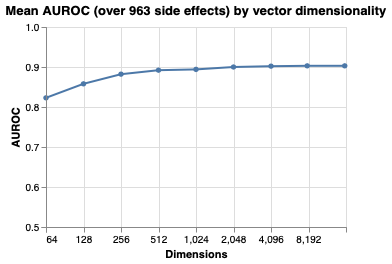

In [29]:
alt.Chart(
    metrics.reset_index().round(3),
    title='Mean AUROC (over 963 side effects) by vector dimensionality'
).mark_line(
    point=True
).encode(
    alt.X(
        'index:Q',
        title='Dimensions',
        scale=alt.Scale(type='log', base=2)
    ),
    alt.Y(
        'mean_auroc',
        title="AUROC",
        scale=alt.Scale(domain=[0.5, 1])
    ),
    tooltip=['mean_auroc', 'mean_auprc', 'mean_ap50']
).properties(width=300,height=200)

## UMAP

Use the Uniform Manifold Approximation and Projections (UMAP) library to create a 2-dimensional visualization of the vector space. In theory, similar concepts should result in similar embeddings, so we might expect the representations to cluster in some way, e.g. by side effect category.

In [30]:
predicate_vectors = semvec.readfile('../zenodo/esp_vectors_16k_8cycles/predicatevectors.bin')

# For the purposes of UMAP, remove reverse side effects and inverse relationships produced by ESP
df = pd.DataFrame(predicate_vectors[0])
indices = df[(~df[0].str.endswith("-2")) &
             (~df[0].str.endswith("-INV"))].index.tolist()
len(indices)

16000   BINARY


965

In [31]:
predicate_vectors = ([predicate_vectors[0][i] for i in indices], [
                     predicate_vectors[1][i] for i in indices])
len(predicate_vectors), len(predicate_vectors[0])

(2, 965)

Get side effect categories

In [32]:
%%bash
mkdir -p ../bio-decagon
cd ../bio-decagon/

wget http://snap.stanford.edu/decagon/bio-decagon-effectcategories.tar.gz
tar -zxvf bio-decagon-effectcategories.tar.gz

--2019-10-27 23:30:40--  http://snap.stanford.edu/decagon/bio-decagon-effectcategories.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7742 (7.6K) [application/x-gzip]
Saving to: ‘bio-decagon-effectcategories.tar.gz.1’

     0K .......                                               100%  203K=0.04s

2019-10-27 23:30:40 (203 KB/s) - ‘bio-decagon-effectcategories.tar.gz.1’ saved [7742/7742]

x ./._bio-decagon-effectcategories.csv
x bio-decagon-effectcategories.csv


In [33]:
# Load side effect classes
file_location = "../bio-decagon/"
se_classes = pd.read_csv(file_location + "bio-decagon-effectcategories.csv")
se_classes.columns = ['side_effect', 'side_effect_name', 'disease_class']
se_classes.side_effect_name = se_classes.side_effect_name.apply(
    lambda x: x.replace(" ", "_").upper())
print(len(se_classes))
se_classes.head()

561


,side_effect,side_effect_name,disease_class
0,C0017152,GASTRIC_INFLAMMATION,gastrointestinal system disease
1,C0027858,NEUROMA,benign neoplasm
2,C0041466,TYPHOID,bacterial infectious disease
3,C0032807,POST_THROMBOTIC_SYNDROME,cardiovascular system disease
4,C0033860,PSORIASIS,integumentary system disease


In [34]:
# eliminate redundancy
se_classes.disease_class = se_classes.disease_class.apply(lambda x: 'hematopoietic system disease' if x=='hematopoietic system diseases' else x)

In [35]:
se_classes = se_classes.set_index('side_effect_name').disease_class.to_dict()

Add side effect classes to our vector data

In [36]:
targets = pd.DataFrame(predicate_vectors[0])
targets['target'] = targets[0].apply(lambda x: se_classes[x] if x in se_classes else 'other')
targets = targets.set_index(0)
targets.head()

,target
0,
PANCREATITIS_RELAPSING,other
VESTIBULAR_DISORDER,nervous system disease
HAIR_DISEASE,integumentary system disease
CLOTTING,hematopoietic system disease
INFLAMMATORY_BOWEL_DISEASE,gastrointestinal system disease


In [37]:
most_frequent_except_other = targets.target.value_counts().sort_values(ascending=False).reset_index().rename(columns={'target':'count', 'index':'class_name'}).class_name.tolist()[1:]
most_frequent_except_other

['nervous system disease',
 'cardiovascular system disease',
 'gastrointestinal system disease',
 'musculoskeletal system disease',
 'integumentary system disease',
 'respiratory system disease',
 'cancer',
 'urinary system disease',
 'hematopoietic system disease',
 'acquired metabolic disease',
 'endocrine system disease',
 'viral infectious disease',
 'reproductive system disease',
 'immune system disease',
 'fungal infectious disease',
 'benign neoplasm',
 'cognitive disorder',
 'inherited metabolic disorder',
 'thoracic disease',
 'developmental disorder of mental health',
 'bacterial infectious disease',
 'substance-related disorder',
 'psoriatic arthritis',
 'sexual disorder',
 'somatoform disorder',
 'personality disorder',
 'sleep disorder',
 'irritable bowel syndrome',
 'pre-malignant neoplasm']

In [38]:
import umap, matplotlib.pyplot as plt, numpy as np
points = umap.UMAP(random_state=42).fit_transform([bits.tolist() for bits in predicate_vectors[1]])

# Optionally t-SNE:
# from sklearn.manifold import TSNE
# points=TSNE(random_state=42).fit_transform(bit_df)

len(points)

/Users/hannah/anaconda3/envs/predicting_ddis_with_esp_env/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/Users/hannah/anaconda3/envs/predicting_ddis_with_esp_env/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../anaconda3/envs/predicting_ddis_with_esp_env/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/hannah/anaconda3/envs/predicting_ddis_with_esp_env/lib/python3.6/site-packages/numba/compiler.py:742: NumbaWarning: 

965

In [39]:
points_df = pd.DataFrame(points)
points_df['group'] = targets.reset_index().target
points_df['side_effect'] = targets.reset_index()[0]
points_df.columns=["x","y",'group','side_effect']
points_df.head()

,x,y,group,side_effect
0,0.050136,0.389523,other,PANCREATITIS_RELAPSING
1,2.339639,0.782053,nervous system disease,VESTIBULAR_DISORDER
2,3.465954,-0.073128,integumentary system disease,HAIR_DISEASE
3,4.053017,-3.874461,hematopoietic system disease,CLOTTING
4,1.557749,2.067807,gastrointestinal system disease,INFLAMMATORY_BOWEL_DISEASE


In [40]:
points_df.group.unique()

array(['other', 'nervous system disease', 'integumentary system disease',
       'hematopoietic system disease', 'gastrointestinal system disease',
       'somatoform disorder', 'respiratory system disease',
       'cardiovascular system disease', 'musculoskeletal system disease',
       'bacterial infectious disease', 'fungal infectious disease',
       'substance-related disorder', 'acquired metabolic disease',
       'thoracic disease', 'urinary system disease', 'cancer',
       'endocrine system disease', 'irritable bowel syndrome',
       'cognitive disorder', 'viral infectious disease',
       'reproductive system disease', 'immune system disease',
       'benign neoplasm', 'inherited metabolic disorder',
       'developmental disorder of mental health',
       'pre-malignant neoplasm', 'sexual disorder', 'sleep disorder',
       'personality disorder', 'psoriatic arthritis'], dtype=object)

There are too many classes to visualize nicely in a single graph. We might visualize the most frequent side effects (though the most frequent ones may contain more noise than others), or a random subset.

### Most frequent

In [41]:
groups = most_frequent_except_other[:6]
groups

['nervous system disease',
 'cardiovascular system disease',
 'gastrointestinal system disease',
 'musculoskeletal system disease',
 'integumentary system disease',
 'respiratory system disease']

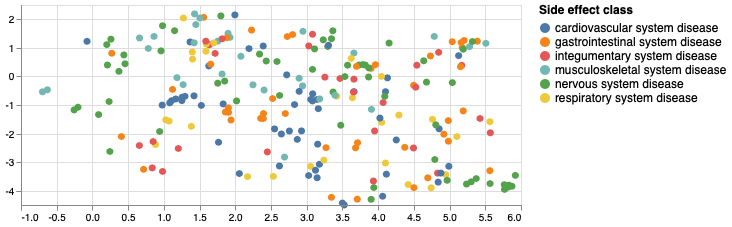

In [42]:
alt.Chart(data=points_df).mark_circle(size=50, opacity=1).encode(
    alt.X("x:Q", title=""),
    alt.Y("y:Q", title=""),
    alt.Color('group:N', title="Side effect class", scale=alt.Scale()),
    alt.Tooltip('side_effect:N')
).transform_filter(
    alt.FieldOneOfPredicate(field='group', oneOf=groups)
).properties(width=500, height=200).configure_legend(labelFontSize=12,labelLimit=250,titleFontSize=12)

### Random

In [43]:
groups = pd.DataFrame(most_frequent_except_other).sample(8, random_state=42)[0].tolist()
groups

['irritable bowel syndrome',
 'cognitive disorder',
 'reproductive system disease',
 'psoriatic arthritis',
 'hematopoietic system disease',
 'acquired metabolic disease',
 'substance-related disorder',
 'nervous system disease']

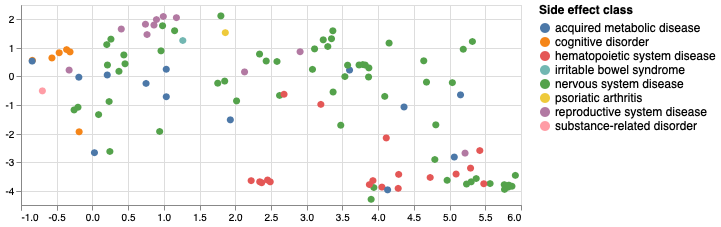

In [44]:
alt.Chart(data=points_df).mark_circle(size=50, opacity=1).encode(
    alt.X("x:Q", title=""),
    alt.Y("y:Q", title=""),
    alt.Color('group:N', title="Side effect class", scale=alt.Scale()),
    alt.Tooltip('side_effect:N')
).transform_filter(
    alt.FieldOneOfPredicate(field='group', oneOf=groups)
).properties(width=500, height=200).configure_legend(labelFontSize=12,labelLimit=250,titleFontSize=12)

### All

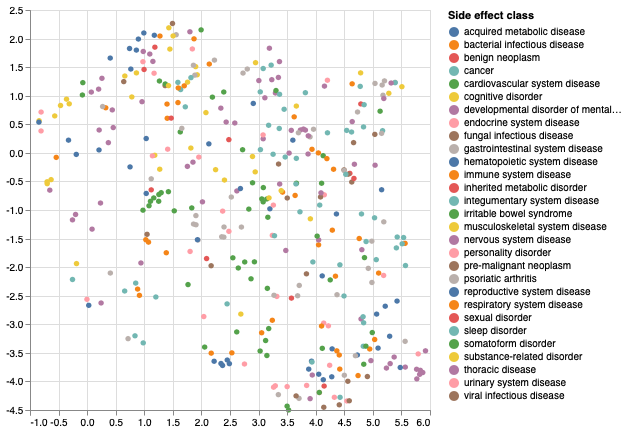

In [45]:
alt.Chart(data=points_df[points_df.group!='other']).mark_circle(opacity=1).encode(
    alt.X("x:Q",title=None),
    alt.Y("y:Q",title=None),
    alt.Color('group:N', title="Side effect class"),
    alt.Tooltip('side_effect:N')
).properties(width=400, height=400)

## Searching for familiar concepts
Another approach to investigation the learned vector space is to search for familiar concepts. Semanticvectors returns the top concepts in order of similarity to the query term.

In [46]:
predicate_vectors = semvec.readfile('../zenodo/esp_vectors_16k_8cycles/predicatevectors.bin')
semantic_vectors = semvec.readfile('../zenodo/esp_vectors_16k_8cycles/semanticvectors.bin')
elemental_vectors = semvec.readfile('../zenodo/esp_vectors_16k_8cycles/elementalvectors.bin')

16000   BINARY
16000   BINARY
16000   BINARY


In [47]:
semvec.search("KIDNEY_FAILURE", predicate_vectors, count=10)

[[1.0, 'KIDNEY_FAILURE'],
 [0.95825, 'KIDNEY_FAILURE-2-INV'],
 [0.904125, 'ACUTE_KIDNEY_FAILURE'],
 [0.902125, 'ACUTE_KIDNEY_FAILURE-2-INV'],
 [0.872875, 'CARDIAC_FAILURE-2-INV'],
 [0.872, 'ANAEMIA-2-INV'],
 [0.871125, 'ANAEMIA'],
 [0.86975, 'CARDIAC_FAILURE'],
 [0.86925, 'BLEEDING-2-INV'],
 [0.868875, 'SEPSIS-2-INV']]

In [48]:
semvec.search("S(aspirin)*E(warfarin)", predicate_vectors, semantic_vectors=semantic_vectors, predicate_vectors=predicate_vectors, elemental_vectors=elemental_vectors, search_type='boundproduct')

[[0.36275, 'FIBROSING_ALVEOLITIS'],
 [0.347375, 'PAROTITIS'],
 [0.346, 'FIBROSING_ALVEOLITIS-2-INV'],
 [0.343125, 'GOUTY_ARTHRITIS-2-INV'],
 [0.34075, 'HAEMARTHROSIS'],
 [0.339125, 'NECK_MASS'],
 [0.338875, 'PAROTITIS-2-INV'],
 [0.336125, 'HERNIA_INGUINAL'],
 [0.33575, 'NECK_MASS-2-INV'],
 [0.33525, 'MPD'],
 [0.332125, 'THROMBOPHLEBITIS-2-INV'],
 [0.33175, 'LUNG_ADENOCARCINOMA'],
 [0.331625, 'CUTANEOUS_MYCOSIS'],
 [0.330875, 'CUTANEOUS_MYCOSIS-2-INV'],
 [0.329, 'HAEMARTHROSIS-2-INV'],
 [0.328625, 'BREAST_ENLARGEMENT-2-INV'],
 [0.328375, 'ARTHRITIS_BACTERIAL'],
 [0.32825, 'PLATELET_DISORDER'],
 [0.326375, 'MPD-2-INV'],
 [0.325875, 'IRRITATION_SKIN-2-INV']]

# Decagon evaluation
The scores here were produced with our own version of the Decagon code, available in the companion repository at https://github.com/hannahburkhardt/decagon. The model was trained for 8 epochs, which was not enough to achieve convergence. The scores here are provided for reference and do not reflect the best possible Decagon performance.

In [49]:
file_location = "../zenodo/"
decagon_scores = pd.read_csv(
    file_location + "decagon_scores_8_epochs.txt", sep="\t")
decagon_scores.columns = ["subject_name",
                          "predicate_name", "object_name", "result", "truth"]
print(decagon_scores.dtypes)
decagon_scores.head()

subject_name       object
predicate_name     object
object_name        object
result            float64
truth             float64
dtype: object


,subject_name,predicate_name,object_name,result,truth
0,CID000002244,C0004144,CID000003365,0.860732,1.0
1,CID000003440,C0004144,CID000004691,0.625638,1.0
2,CID000003957,C0004144,CID000004075,0.691289,1.0
3,CID000004168,C0004144,CID000005090,0.589250,1.0
4,CID000001117,C0004144,CID000077993,0.268906,1.0


In [50]:
[len(decagon_scores), len(
    decagon_scores[~decagon_scores.predicate_name.str.contains("_2")])]

[1828784, 914392]

In [51]:
decagon_scores = decagon_scores[~decagon_scores.predicate_name.str.contains(
    "_2")]
positive_decagon_scores = decagon_scores[decagon_scores.truth == 1]
negative_decagon_scores = decagon_scores[decagon_scores.truth == 0]

positive_examples = positive_decagon_scores[[
    'subject_name', 'predicate_name', 'object_name']]
pos_scores = positive_decagon_scores[['result']]
pos_scores.columns = [0]

negative_examples = negative_decagon_scores[[
    'subject_name', 'predicate_name', 'object_name']]
neg_scores = negative_decagon_scores[['result']]
neg_scores.columns = [0]

[len(positive_examples), len(negative_examples)]

[457196, 457196]

In [52]:
len(decagon_scores.predicate_name.unique())

963

Positive results mean score: 0.651
Negative results mean score: 0.198
Overall AUROC: 0.881
Overall AUPRC: 0.813
Overall AP50: 0.526

Average performance over 963 side effects:
       median   mean    std    sem    min    max
auroc   0.876  0.855  0.073  0.002  0.259  0.949
auprc   0.810  0.793  0.067  0.002  0.366  0.934
ap50    0.648  0.638  0.126  0.004  0.066  0.950


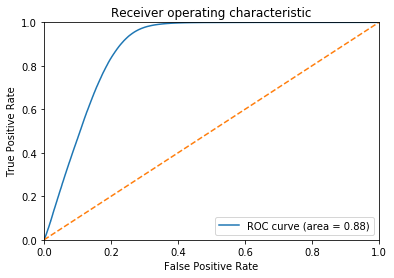

In [53]:
decagon_aurocs_by_se = esp_ddi_util.get_aurocs_by_side_effect(
    negative_examples=negative_examples, positive_examples=positive_examples, negative_results=neg_scores, positive_results=pos_scores)

In [54]:
for c in ['auroc', 'auprc', 'ap50']:
    print(c)
    print('min:', side_effect_names[decagon_aurocs_by_se[c].idxmin()], round(decagon_aurocs_by_se[c].min(
    ), 3), 'max:', side_effect_names[decagon_aurocs_by_se[c].idxmax()], round(decagon_aurocs_by_se[c].max(), 3))
    print()

auroc
min: HYPERMETROPIA 0.259 max: GASTRIC_ULCER_PERFORATED 0.949

auprc
min: HYPERMETROPIA 0.366 max: GALACTORRHEA 0.934

ap50
min: HYPERMETROPIA 0.066 max: SYNCOPE_VASOVAGAL 0.95



### Performance distribution

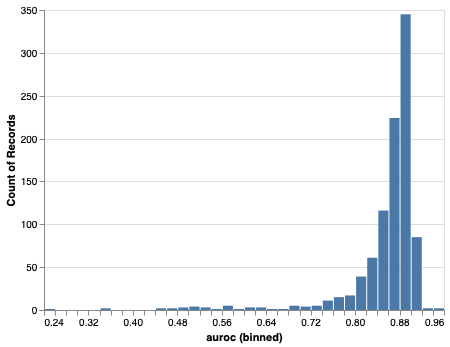

In [56]:
alt.Chart(decagon_aurocs_by_se).mark_bar().encode(
    x=alt.X(
        'auroc', 
        bin=alt.Bin(maxbins=50)
    ), 
    y='count()', 
    tooltip=[
        alt.Tooltip('count()')
    ]
)

### Performance by side effect frequency

In [57]:
df = decagon_aurocs_by_se.reset_index()
df.predicate_name = df.predicate_name.astype(
    'category').cat.rename_categories(side_effect_names)
df.head()
decagon_aurocs_by_se = df.set_index('predicate_name')

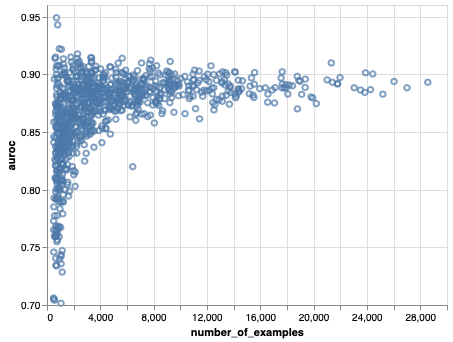

In [58]:
# the positive testing examples constitute 10% of the total number of samples in the dataset
alt.Chart(
    decagon_aurocs_by_se.reset_index()
).mark_point().encode(
    alt.Y(
        'auroc',
        scale=alt.Scale(zero=False)
    ),
    x='number_of_examples:Q',
    tooltip=['predicate_name', 'number_of_examples:Q']
).transform_calculate(
    number_of_examples=alt.datum.positive_examples*10
).transform_filter(alt.datum.auroc>0.7)

This chart shows that Decagon performs generally well on frequent side effects, while rarer side effects vary widely in performance, with some as low as 0.3.

### Score distribution by label

In [59]:
pos_scores['truth'] = 1
neg_scores['truth'] = 0
scores = pos_scores.append(neg_scores)
scores.columns = ['score', 'truth']
scores.head()

/Users/hannah/anaconda3/envs/predicting_ddis_with_esp_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/hannah/anaconda3/envs/predicting_ddis_with_esp_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,score,truth
0,0.860732,1
1,0.625638,1
2,0.691289,1
3,0.589250,1
4,0.268906,1


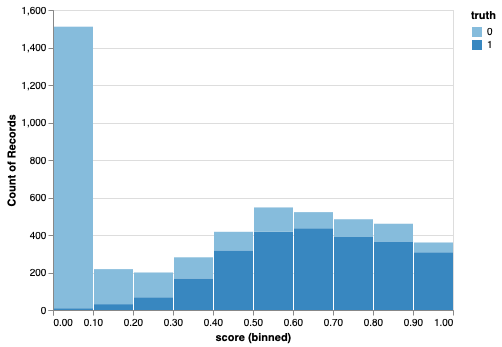

In [60]:
alt.Chart(scores.sample(5000)).mark_bar().encode(
    x=alt.X("score", bin=True), 
    y='count()', 
    color='truth:O'
)

Here we can see that Decagon gives a large portion of the negatives very low scores (<0.1)!

# Comparison of best and worst side effects between ESP and Decagon

In [61]:
print("Best ESP side effects:")
pd.DataFrame(esp_aurocs_by_se[['auprc']].sort_values(
    by="auprc", ascending=False).auprc.apply(lambda x: ("%.3f" % x))).head(5)

Best ESP side effects:


,auprc
predicate_name,
MUMPS,0.976
ANAEMIA_HYPOCHROMIC,0.972
DYSHIDROSIS,0.971
CARCINOMA_OF_THE_CERVIX,0.970
FRACTURE_NONUNION,0.965


In [62]:
print("Worst ESP side effects:")
pd.DataFrame(esp_aurocs_by_se[['auprc']].sort_values(by="auprc",ascending=True).auprc.apply(lambda x: ("%.3f"%x))).head(5)

Worst ESP side effects:


,auprc
predicate_name,
CAESAREAN_SECTION,0.779
INTERSTITIAL_NEPHRITIS,0.790
MOUTH_BLEEDING,0.790
BRONCHIOLITIS,0.794
EMESIS,0.798


Compare to Decagon's reported best and worst side effects

In [63]:
decagon_reported = pd.DataFrame({"MUMPS" : 0.964,
"BLEEDING" : 0.679,
"CARBUNCLE" : 0.949,
"BODY_TEMPERATURE_INCREASED" : 0.680,
"COCCYDYNIA" : 0.943,
"EMESIS" : 0.693,
"TYMPANIC_MEMBRANE_PERFORATION" : 0.941,
"DISORDER_RENAL" : 0.694,
"DYSHIDROSIS" : 0.938,
"LEUCOPENIA" : 0.695,
"SPONDYLOSIS" : 0.929,
"DIARRHEA" : 0.705,
"SCHIZOAFFECTIVE_DISORDER" : 0.919,
"ICTERUS" : 0.707,
"BREAST_DYSPLASIA" : 0.918,
"NAUSEA" : 0.711,
"GANGLION" : 0.909,
"ITCH" : 0.712,
"UTERINE_POLYP" : 0.908,
"ANAEMIA" : 0.712}, index=['decagon_reported_auprc']).transpose()
decagon_reported.head()

,decagon_reported_auprc
MUMPS,0.964
BLEEDING,0.679
CARBUNCLE,0.949
BODY_TEMPERATURE_INCREASED,0.680
COCCYDYNIA,0.943


In [64]:
best_and_worst = decagon_reported.merge(esp_aurocs_by_se.auprc.rename(
    'esp_auprc'), how='left', left_index=True, right_index=True)
best_and_worst.sort_values(by='decagon_reported_auprc', ascending=False).round(3)

,decagon_reported_auprc,esp_auprc
MUMPS,0.964,0.976
CARBUNCLE,0.949,0.924
COCCYDYNIA,0.943,0.930
TYMPANIC_MEMBRANE_PERFORATION,0.941,0.929
DYSHIDROSIS,0.938,0.971
SPONDYLOSIS,0.929,0.940
SCHIZOAFFECTIVE_DISORDER,0.919,0.946
BREAST_DYSPLASIA,0.918,0.909
GANGLION,0.909,0.946
UTERINE_POLYP,0.908,0.903


This chart shows that the best performing side effects for Decagon and ESP are in the similar general region; however, ESP performs much better on side effects that Decagon models poorly.

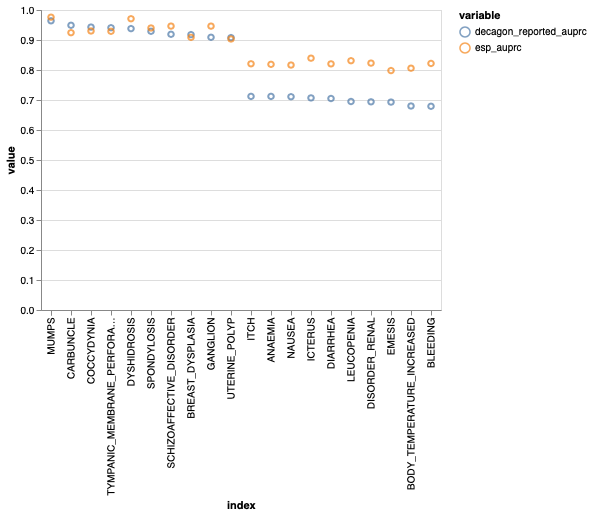

In [65]:
alt.Chart(
    best_and_worst.reset_index().melt(id_vars='index')
).mark_point(
).encode(
    x=alt.X('index', sort=decagon_reported.sort_values(
        by='decagon_reported_auprc', ascending=False).index.tolist()),
    y='value',
    color='variable'
)